In [12]:
# Loading packages
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import pickle
import cv2 

import logging
# from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

from dataset import MaskDataset, get_img_files
from nets.MobileNetV2_unet import MobileNetV2_unet
from nets.mobilenet import MobileNetV2 as MNV2
import sys

import torch
import torchvision
import torch.autograd as autograd
import torchvision.transforms as T

In [ ]:
train_file_list = []
test_file_list = []
image = []
label_1= []
label_2= []
with open('../data/training/images_info_train.json') as json_file:  
    data = json.load(json_file)
    tcount = 0
    for keys,values in data.items():
        for y in values:
#             if y['id'] > 5000:
#                 test_file_list.append(y['file_name'])
#             else:
#                 train_file_list.append(y['file_name'])
                test_file_list.append(y['file_name'])

#Try read images
train_image_path = '../data/training/images'
for test_file in test_file_list:
    I = Image.open(os.path.join(train_image_path,test_file)).convert('RGB')   
    I_array = np.array(I)
    image.append(I_array)
    #print(I_array.shape)
    #print(I.shape,' ', test_file)

train_2ch_path = '../data/training/annos_2ch/'
for test_file in test_file_list:
    test_file = test_file[0:4]
    test_file = test_file + '.png'
    I = Image.open(os.path.join(train_2ch_path,test_file))   
    I_array= np.array(I)
#     print(I_array.shape)
    label_1.append(I_array[:,:,0])
    label_2.append(I_array[:,:,1])
    #print(I_array.shape)



In [ ]:
# save images and labels into npy file
np.save("../data/training/images.npy",image)
np.save("../data/training/sem_labels.npy",label_1)
np.save("../data/training/ins_labels.npy",label_2)

In [13]:
# load images and labels
image=np.load("../data/training/images.npy")
sem_label=np.load("../data/training/sem_labels.npy")
ins_label=np.load("../data/training/ins_labels.npy")

In [14]:
image=np.array(image)
sem_label=np.array(sem_label)
ins_label=np.array(ins_label)
print(image.shape)
print(sem_label.shape)
print(ins_label.shape)


(5087,)
(5087,)
(5087,)


In [15]:
def preprocess(img, size=(224, 224)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [16]:
class ToLabel:
    def __call__(self, image):
        return torch.from_numpy(np.array(image)).long().unsqueeze(0)
target_transform = Compose([
    # CenterCrop(640),
    Resize((128,128)),
    ToLabel(),
])

In [17]:
    net = MobileNetV2_unet(pre_trained=None)
    #net.load_state_dict(torch.load('weights/mobilenet_VOC.pth'))

In [18]:
    X_tensor = torch.cat([preprocess(PIL.Image.fromarray(x)) for x in image[0:10]], dim=0)
    y_tensor = torch.cat([preprocess(PIL.Image.fromarray(x))*255+0.5 for x in sem_label[0:10]], dim=0).long()
    print(X_tensor.size())
    print(y_tensor.size())
    print(y_tensor[1])
    print(sem_label[1])
    output=net.forward(X_tensor)

torch.Size([10, 3, 224, 224])
torch.Size([10, 1, 224, 224])
tensor([[[21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]])
[[21 21 21 ... 21 21 21]
 [21 21 21 ... 21 21 21]
 [21 21 21 ... 21 21 21]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
torch.Size([10, 16, 112, 112])
torch.Size([10, 24, 56, 56])
torch.Size([10, 32, 28, 28])
torch.Size([10, 96, 14, 14])
torch.Size([10, 320, 7, 7])


In [19]:
print(output.size())
print(output[0].size())
print(output[0][:,0,0])
print(output[0][:,0,0].size())

torch.Size([10, 25, 224, 224])
torch.Size([25, 224, 224])
tensor([0.4045, 0.3594, 0.5681, 0.3309, 0.5989, 0.3497, 0.4206, 0.4023, 0.4671,
        0.5229, 0.4230, 0.4919, 0.5027, 0.4938, 0.4407, 0.5275, 0.5583, 0.5728,
        0.6601, 0.6889, 0.6150, 0.5894, 0.5935, 0.5036, 0.5357],
       grad_fn=<SelectBackward>)
torch.Size([25])


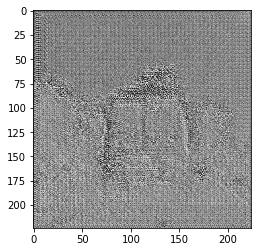

In [20]:
#output = output[0].detach().numpy()*255 #10*224*224
output_np = deprocess(output[0].clone())
plt.imshow(output_np)

In [31]:
def CrossEntropy_loss(X, target):
    loss = torch.nn.CrossEntropyLoss()
    X = X.transpose(1,3)
    target = target.transpose(1,3)
    target.squeeze()
    X = X.reshape(224*224*10,25)
    target = target.reshape(-1)
    
    return loss(X,target)


In [32]:
input = output
target = y_tensor
loss = CrossEntropy_loss(input, target)
print(loss)


tensor(3.2252, grad_fn=<NllLossBackward>)


In [ ]:
# Enable gradient computation on image
img_var = autograd.Variable(output, requires_grad=True)

# Set up optimization hyperparameters
initial_lr = 0.1
decayed_lr = 0.1
decay_lr_at = 180

# optimizing the pixel values of the image by passing in the img_var Torch variable
# optimizer = torch.optim.Adam([img_var], lr=initial_lr)
optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)
optimizer.zero_grad()
loss.backward()
optimizer.step()